In [1]:
%cd /Users/gwg/local/dmcm
%matplotlib inline

import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

import torch
from   torch import nn
from   torchvision.utils import save_image

from   data import CelebAConfig, CelebADataset
from   models import AlexNetVAEBN
import plotutils

/Users/gwg/local/dmcm


In [7]:
cfg     = CelebAConfig()
dataset = CelebADataset(cfg)

In [9]:
LATENT_DIM = 512
cfg.LATENT_DIM = LATENT_DIM
LR = '0.0001'

fname   = '/Users/gwg/local/dmcm/experiments/ivae/'\
          'celeba_dim-%s_lr-%s_epochs-900' % (LATENT_DIM, LR)
state   = torch.load('%s/model.pt' % fname, map_location={'cuda:0': 'cpu'})
model   = nn.DataParallel(AlexNetVAEBN(cfg))
model.load_state_dict(state)

Text(0.5,1,'Test KLD error')

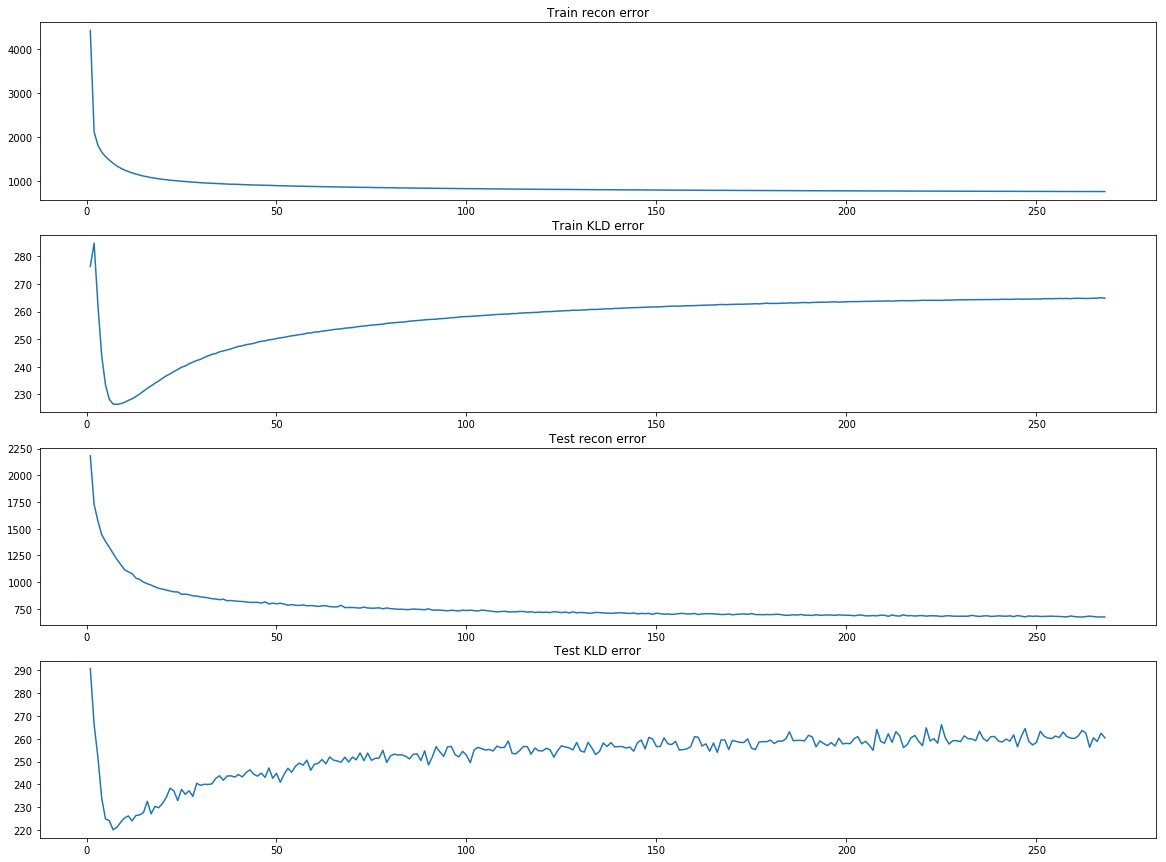

In [10]:
fpath   = '%s/out.txt' % fname
data    = np.array(plotutils.parse_vae_file(fpath))
# Remove the first N for visualization purposes.
N       = 0

x      = data[:, 0:1][N:]
rec_tr = data[:, 1:2][N:]
kld_tr = data[:, 2:3][N:]
rec_te = data[:, 3:4][N:]
kld_te = data[:, 4:5][N:]

fig, axs = plt.subplots(4, 1, figsize=(20, 15))

axs[0].plot(x, rec_tr)
axs[0].set_title('Train recon error')

axs[1].plot(x, kld_tr)
axs[1].set_title('Train KLD error')

axs[2].plot(x, rec_te)
axs[2].set_title('Test recon error')

axs[3].plot(x, kld_te)
axs[3].set_title('Test KLD error')

In [16]:
for j in range(10):

    origin   = torch.randn(1, cfg.LATENT_DIM)
    batch    = torch.Tensor(64, cfg.LATENT_DIM)
    batch[0] = origin

    pos   = np.random.randn()
    delta = 0
    INC   = 0.02
    for i in range(63):
        if pos:
            delta += INC
        else:
            delta -= INC
        batch[i+1] = origin + delta

    sample = model.module.decode(batch)
    img    = sample.view(64, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
    save_image(img, '/Users/gwg/Desktop/fantasy/%s.png' % j)